In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import xarray as xr
import fsspec
import cftime
import intake
import vcm

from vcm import  mass_integrate
from vcm.calc.thermo import column_integrated_heating_from_isochoric_transition, minus_column_integrated_moistening, latent_heat_vaporization
from fv3viz import plot_cube, mappable_var
from vcm.catalog import catalog

import numpy as np

def zonal_mean(
    ds: xr.Dataset, latitude: xr.DataArray, bins=np.arange(-90, 91, 2)
) -> xr.Dataset:
    zm = ds.groupby_bins(latitude, bins=bins).mean().rename(lat_bins="latitude")
    latitude_midpoints = [x.item().mid for x in zm["latitude"]]
    return zm.assign_coords(latitude=latitude_midpoints)






In [ ]:
N2F_TENDENCIES_PATH = "gs://vcm-ml-experiments/2021-04-13-n2f-c3072/3-hrly-ave-rad-precip-setting-30-min-rad-timestep-shifted-start-tke-edmf/nudging_tendencies.zarr"
n2f_tendencies = intake.open_zarr(N2F_TENDENCIES_PATH).to_dask()

wind_rotation_matrix = catalog["wind_rotation/c48"].read()
grid=catalog["grid/c48"].read()

n2f_tendencies["dQu"], n2f_tendencies["dQv"] = vcm.cubedsphere.center_and_rotate_xy_winds(
    wind_rotation_matrix,
    n2f_tendencies["x_wind_tendency_due_to_nudging"],
    n2f_tendencies["y_wind_tendency_due_to_nudging"],
)

n2f_state = intake.open_zarr("gs://vcm-ml-experiments/2021-04-13-n2f-c3072/3-hrly-ave-rad-precip-setting-30-min-rad-timestep-shifted-start-tke-edmf/state_after_timestep.zarr").to_dask().sel(time=n2f_tendencies.time)
n2f_tendencies["pressure_thickness_of_atmospheric_layer"] = n2f_state["pressure_thickness_of_atmospheric_layer"]

In [16]:
pressure_level_northward_wind = vcm.interpolate_to_pressure_levels(
         n2f_tendencies["dQv"], delp=n2f_tendencies["pressure_thickness_of_atmospheric_layer"], dim="z"
)

dQv_time_mean_zonal_pressure_level = zonal_mean(pressure_level_northward_wind, grid.lat).mean("time").load()

/home/AnnaK/fv3net/external/vcm/vcm/interpolate.py:147: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_dtypes=[field.dtype],
/home/AnnaK/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/AnnaK/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/AnnaK/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


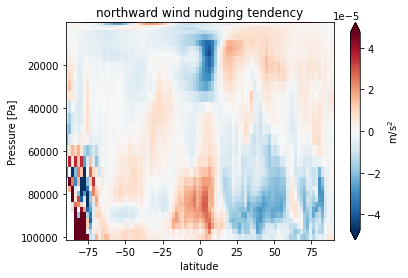

In [49]:
fig, ax = plt.subplots()
f = dQv_time_mean_zonal_pressure_level.plot(robust=True, yincrease=False, )
plt.title("northward wind nudging tendency")
ax.set_ylabel("Pressure [Pa]")
f.colorbar.set_label("m/s$^2$")
plt.savefig("figures/nudging_zonal_pressure_northwind_tendency_time_mean.png", bbox_inches = "tight")
